# Model and Dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
# Training Parameters:
lr = 0.1
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 128
test_batch_size = 100

Train_Flag = False

In [3]:
# Preparing Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])


dataset_train = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)

dataset_test = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(
    dataset_test, batch_size=test_batch_size, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Model
print('==> Building model..')
model = torchvision.models.vgg16_bn(pretrained=False).to(device)
model.classifier = torch.nn.Linear(in_features=25088, out_features=10)
model = model.to(device)


==> Building model..


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)



In [6]:


# Training
def train(model, epoch, trainloader, optimizer, criterion, verbose = True):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in tqdm (enumerate(trainloader), total = len (trainloader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        torch.cuda.empty_cache()
        if verbose:
            print (f"epoch:{epoch}, {batch_idx}/{len(trainloader)}", 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                             % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


def test(model, epoch, testloader, criterion, verbose = True):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in tqdm (enumerate(testloader), total = len (testloader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            if verbose:
                print (f"epoch:{epoch}, {batch_idx}/{len(testloader)}", 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                             % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

                

    # Save checkpoint.
    acc = 100.*correct/total
    torch.cuda.empty_cache()
    return acc




In [7]:
if Train_Flag:
    best_acc = 0  # best test accuracy
    for epoch in tqdm (range(200)):
        train(model, epoch, train_loader, optimizer, criterion)
        acc = test(model, epoch, test_loader, criterion)
        scheduler.step()
        
        if acc > best_acc:
            print('Saving..')
            torch.save(model.state_dict(), 'ckpt.pth')
            best_acc = acc

else:
    model.load_state_dict (torch.load("ckpt.pth"))
    epoch = 0
    acc = test (model, epoch, test_loader, criterion, verbose = False)
    print ("loaded pretrained model with", acc, "% accuracy on test images")


loaded pretrained model with 94.08 % accuracy on test images


In [8]:
def filter_mask(mask, topp = 0.2):
    mask_torch = mask
    if isinstance (mask , np.ndarray):
        mask_torch = torch.tensor(mask)
    mask_linear = mask_torch.reshape(-1)
    _, mask_sortedargs = mask_linear.sort()
    mask_ones = torch.ones(len(mask_linear))
    mask_ones[:int(len(mask_linear) * (1-topp))] = 0.0
    mask_linear = mask_ones[mask_sortedargs.argsort()]
    
    return mask_linear.reshape(mask.shape)

class MaskedDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, masks):
        self.data = data
        self.labels = labels
        self.masks = masks
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        
        filtered_mask = filter_mask (self.masks[idx])
        img = img * filtered_mask

        return img, label

def generate_masked_dataset(dataset, mask_generator, max_iters = 100):
    masks = []
    images = []
    labels = []
    
    if max_iters is not None:
        max_iters = min(max_iters, len(dataset))
    else:
        max_iters = len(dataset)
    
    dataloader = torch.utils.data.DataLoader(dataset, 1, shuffle = True)
    for i, (x,y) in tqdm (enumerate (dataloader), total = max_iters):
        x, y = deepcopy (x[0]), deepcopy (y[0])
        images.append(x)
        labels.append(y)    
        mask = mask_generator(x, y)
        masks.append(mask)
        if i > max_iters:
            break
    return MaskedDataset(images, labels, masks)


# lime

In [9]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
model_lime = deepcopy (model)

In [10]:
def batch_predict(images):
    model_lime.eval()
    batch = torch.stack(tuple(torch.tensor (i).permute([2,0,1]) for i in images), dim=0)

    if (batch.dtype == torch.float64):
        batch = batch.to(torch.float32)  

    if (batch.dtype == torch.uint8):
        batch = batch.float()/255     

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_lime.to(device)
    batch = batch.to(device)
    
    logits = model_lime(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [11]:
segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=1,
                                        max_dist=5, ratio=0.1,
                                        random_seed=100)

def limeExplanation(img, label):
    # img shape: [C, H, W]
    img = img.permute ([1,2,0]).to(torch.float64).numpy()
    explainer = lime_image.LimeImageExplainer(verbose = False)
    explanation = explainer.explain_instance(img, 
                                             batch_predict, # classification function
                                             top_labels=3, 
                                             hide_color=0, 
                                             num_samples=100, segmentation_fn=segmentation_fn) # number of images that will be sent to classification function
    
    mask_on_img, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features = 3, hide_rest=False)
    img_boundry2 = mark_boundaries(mask_on_img, mask)
    return mask, img_boundry2, mask_on_img

def plotrow(ax, idx, img, mask, img_boundry2, mask_on_img):
    if isinstance(img, torch.Tensor):
        img = img.permute ([1,2,0]).numpy()

    ax[idx,0].imshow(img)
    ax[idx,0].set_title("Input")
    ax[idx,0].axis('off')

    ax[idx,1].imshow(mask)
    ax[idx,1].set_title("mask")
    ax[idx,1].axis('off')

    ax[idx,2].imshow(mask_on_img)
    ax[idx,2].set_title("mask on iamge")
    ax[idx,2].axis('off')

    ax[idx,3].imshow(img_boundry2)
    ax[idx,3].set_title("mask boundaries")
    ax[idx,3].axis('off')

In [12]:
imgs,labels = next (iter (test_loader))


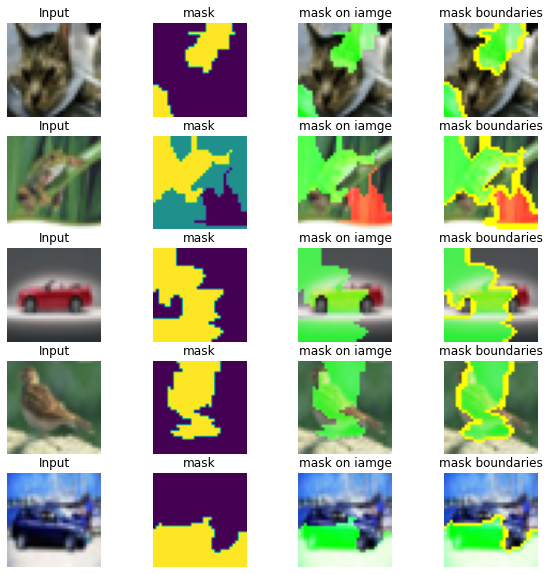

In [13]:

fig, ax = plt.subplots(5,4, figsize=(10, 10))
for i in range(5):
    img = imgs[i]
    label = labels[i].item()
    mask, img_boundry2, mask_on_img = limeExplanation(img, label)
    plotrow(ax, i, img, mask, img_boundry2, mask_on_img)

plt.show()

In [14]:
dataset_test_lime = generate_masked_dataset(dataset_test, mask_generator = lambda x, y : limeExplanation(x,y)[0])
test_loader_lime = torch.utils.data.DataLoader(dataset_test_lime, test_batch_size, shuffle = True)

In [15]:

test(model, epoch, test_loader_lime, criterion, verbose = True)

epoch:0, 0/2 Loss: 4.447 | Acc: 29.000% (29/100)
epoch:0, 1/2 Loss: 5.578 | Acc: 28.431% (29/102)



28.431372549019606

# Shapley (GradientExplainer)

In [16]:
model_shapley = deepcopy (model)

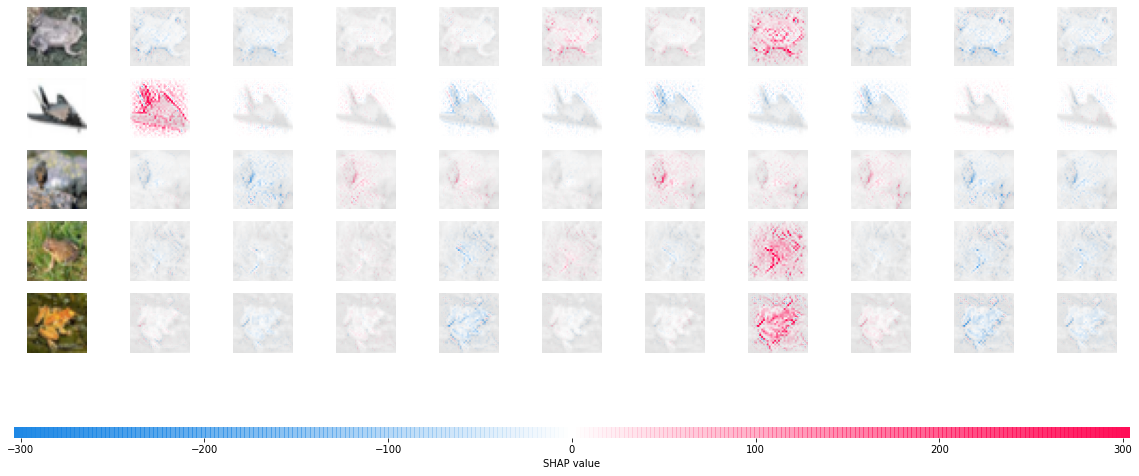

In [17]:
import shap
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, _ = batch
images = images.to(device)
model_shapley.eval()

test_batch_size = len(images)

background = images[:test_batch_size-5]
test_images = images[test_batch_size-5:]

e = shap.DeepExplainer(model_shapley, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)


# plot the feature attributions
shap.image_plot(shap_numpy, test_numpy)

In [18]:
def shapExplanation(x,y):
    shap_values = e.shap_values(x[None].to(device))
    torch.cuda.empty_cache()
    return torch.tensor(shap_values[y][0])

In [19]:
dataset_test_shap = generate_masked_dataset(dataset_test, shapExplanation, max_iters = 10)
test_loader_shap = torch.utils.data.DataLoader(dataset_test_shap, test_batch_size, shuffle = True)

In [20]:

test(model, epoch, test_loader_shap, criterion, verbose = True)

epoch:0, 0/1 Loss: 4.767 | Acc: 25.000% (3/12)



25.0

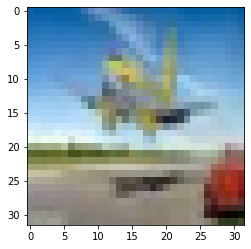

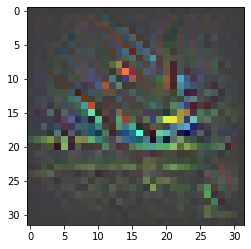

In [21]:
def normalize_and_permute(x):
    no = (x - x.min()) / (x.max() - x.min())
    if len(no.shape) == 3:
        no = no.permute([1,2,0])
    return no

plt.imshow (normalize_and_permute(dataset_test_shap.data[2]), cmap = "gray")
plt.show()
plt.imshow (normalize_and_permute(dataset_test_shap.masks[2]), cmap = "gray")
plt.show()

# lrp

In [45]:
import lrp
from visualization import project, clip_quantile, heatmap_grid, grid
from lrp.patterns import fit_patternnet, fit_patternnet_positive # PatternNet patterns


In [46]:
model_lrp = lrp.convert_vgg(deepcopy (model)).to(device)

In [47]:
patterns = fit_patternnet_positive(model_lrp, train_loader, device=device)

100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:56<00:00,  6.87it/s]


In [48]:

batch = next(iter(test_loader))
x, y = batch
x = x[:6]
y = y[:6]

x = x.to(device)
x = x.requires_grad_(True)

batch_to_append = batch[0][:31].clone()
batch_to_append = batch_to_append
batch_to_append = batch_to_append.requires_grad_(True)

In [49]:
def LRPMask(x, model_lrp, rule, patterns):
    x = x.to(device)
    x = x.detach()
    x.requires_grad_(True)
    
    # Forward pass
    y_hat_lrp = model_lrp.forward(x, explain=True, rule=rule, pattern=patterns)

    # Choose argmax
    y_hat_lrp = y_hat_lrp[torch.arange(x.shape[0]), y_hat_lrp.max(1)[1]]
    y_hat_lrp = y_hat_lrp.sum()

    # Backward pass (compute explanation)
    y_hat_lrp.backward()
    attr = x.grad    
    return attr

def compute_and_plot_explanation(x, model_lrp, rule, ax_, patterns=None, plt_fn=heatmap_grid): 
    
    attr = LRPMask(x, model_lrp, rule, patterns)

    # Plot
    attr = plt_fn(attr)

    ax_.imshow(attr)
    ax_.set_title(rule)
    ax_.axis('off')
# PatternNet is typically handled a bit different, when visualized.
def signal_fn(X):
    if X.shape[1] in [1, 3]: X = X.permute(0, 2, 3, 1).detach().cpu().numpy()
    X = clip_quantile(X)
    X = project(X)
    X = grid(X)
    return X

def lrpExplanation(x, y):
    return LRPMask(torch.cat ([x[None],batch_to_append]), model_lrp, rule = 'alpha1beta0', patterns = None)[0].cpu()

Plotting


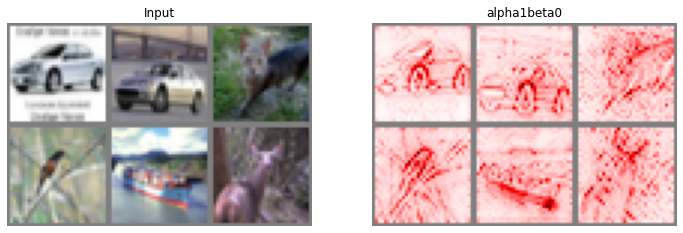

In [181]:
explanations = [
        # rule                  Pattern     plt_fn          Fig. pos
        ('alpha1beta0',         None,       heatmap_grid,   1), 
    ]

fig, ax = plt.subplots(1, 2, figsize=(12, 8))
print("Plotting")

# Plot inputs
input_to_plot = x.permute(0, 2, 3, 1).contiguous().detach().cpu().numpy()
input_to_plot = grid(input_to_plot, 3, 1.)
ax[0].imshow(input_to_plot)
ax[0].set_title("Input")
ax[0].axis('off')

# Plot explanations
for i, (rule, pattern, fn, p ) in enumerate(explanations): 
    compute_and_plot_explanation(x, model_lrp, rule, ax[p], patterns=pattern, plt_fn=fn)



In [51]:
dataset_test_lrp = generate_masked_dataset(dataset_test, lrpExplanation, max_iters=100)

In [52]:
test_loader_lrp = torch.utils.data.DataLoader(dataset_test_lrp, test_batch_size, shuffle = True)
test(model, epoch, test_loader_lrp, criterion, verbose = True)

epoch:0, 0/2 Loss: 5.497 | Acc: 19.000% (19/100)
epoch:0, 1/2 Loss: 5.126 | Acc: 19.608% (20/102)



19.607843137254903

In [30]:
model.features[0].state_dict()['weight'].shape

torch.Size([64, 3, 3, 3])

In [31]:
def normalize_and_permute(x):
    no = (x - x.min()) / (x.max() - x.min())
    if len(no.shape) == 3:
        no = no.permute([1,2,0])
    return no

# Step 6, retraining

In [32]:
# removing augmentations from train dataset

dataset_train_no_transform = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True, transform=transform_test)


Files already downloaded and verified


In [33]:
dataset_train_lrp = generate_masked_dataset(dataset_train_no_transform, lrpExplanation, max_iters=1000)
train_loader_lrp = torch.utils.data.DataLoader(dataset_train_lrp, test_batch_size, shuffle = True)
test(model, epoch, train_loader_lrp, criterion, verbose = True)

epoch:0, 0/11 Loss: 4.766 | Acc: 31.000% (31/100)
epoch:0, 1/11 Loss: 4.875 | Acc: 28.000% (56/200)
epoch:0, 2/11 Loss: 4.970 | Acc: 27.667% (83/300)
epoch:0, 3/11 Loss: 4.934 | Acc: 28.500% (114/400)
epoch:0, 4/11 Loss: 4.863 | Acc: 29.000% (145/500)
epoch:0, 5/11 Loss: 4.866 | Acc: 28.667% (172/600)
epoch:0, 6/11 Loss: 4.951 | Acc: 27.429% (192/700)
epoch:0, 7/11 Loss: 4.960 | Acc: 27.250% (218/800)
epoch:0, 8/11 Loss: 4.989 | Acc: 26.556% (239/900)
epoch:0, 9/11 Loss: 5.020 | Acc: 25.600% (256/1000)
epoch:0, 10/11 Loss: 4.758 | Acc: 25.649% (257/1002)



25.64870259481038

In [34]:
class MixedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset1, dataset2, p = 0.02):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.p = p
        
    def update_indices(self):
        self.indices = np.random.choice(len(self.dataset1), int (len(self.dataset1) * self.p))
                
    def __len__(self):
        return len(self.indices) + len (self.dataset2)

    def __getitem__(self, idx):
        if idx < len (self.dataset2):
#             print ("dataset2")
            return self.dataset2.__getitem__(idx)
        else:
#             print ("dataset1")
            new_idx = idx - len(self.dataset2)
            img, label = self.dataset1.__getitem__(new_idx)
            return img, torch.tensor(label)
        

In [35]:
mixedDataset = MixedDataset(dataset_train , dataset_train_lrp)
mixedDataset.update_indices()
mixed_loader = torch.utils.data.DataLoader (mixedDataset, batch_size, shuffle = True)

In [36]:
from copy import deepcopy
with torch.no_grad():
    model_retrained = deepcopy(model)

optimizer_retrain = optim.SGD(model_retrained.parameters(), lr=0.0001, momentum=0.9, weight_decay=5e-4)

In [37]:
acc1 = test(model_retrained, epoch, test_loader, criterion, verbose = False)
acc2 = test(model_retrained, epoch, train_loader_lrp, criterion, verbose = False)
acc3 = test(model_retrained, epoch, test_loader_lrp, criterion, verbose = False)
print (f"acc1:{acc1},", f"acc2:{acc2},",  f"acc3:{acc3},")


acc1:94.08, acc2:25.64870259481038, acc3:22.54901960784314,


In [38]:
best_acc = 0  # best test accuracy
for epoch in tqdm (range(20)):
    mixedDataset.update_indices()
    
    train(model_retrained, epoch, mixed_loader, optimizer_retrain, criterion)
    
    model_lrp = lrp.convert_vgg(deepcopy (model_retrained)).to(device)
    
    
    dataset_train_lrp = generate_masked_dataset(dataset_train_no_transform, lrpExplanation, max_iters=1000)
    mixedDataset = MixedDataset(dataset_train , dataset_train_lrp)
    mixedDataset.update_indices()
    mixed_loader = torch.utils.data.DataLoader (mixedDataset, batch_size, shuffle = True)
    
    dataset_test_lrp = generate_masked_dataset(dataset_test, lrpExplanation, max_iters=100)
    test_loader_lrp = torch.utils.data.DataLoader(dataset_test_lrp, test_batch_size, shuffle = True)
    
    acc1 = test(model_retrained, epoch, test_loader, criterion, verbose = False)
    acc2 = test(model_retrained, epoch, train_loader_lrp, criterion, verbose = False)
    acc3 = test(model_retrained, epoch, test_loader_lrp, criterion, verbose = False)
    print (f"acc1: {acc1} | ", f"acc2: {acc2} | ",  f"acc3: {acc3},")

#     if acc > best_acc:
#         print('Saving..')
#         torch.save(model.state_dict(), 'ckpt.pth')
#         best_acc = acc


Epoch: 0


epoch:0, 0/16 Loss: 0.927 | Acc: 77.344% (99/128)
epoch:0, 1/16 Loss: 1.027 | Acc: 78.516% (201/256)
epoch:0, 2/16 Loss: 1.088 | Acc: 79.167% (304/384)
epoch:0, 3/16 Loss: 1.080 | Acc: 79.883% (409/512)
epoch:0, 4/16 Loss: 1.086 | Acc: 78.906% (505/640)
epoch:0, 5/16 Loss: 1.099 | Acc: 78.255% (601/768)
epoch:0, 6/16 Loss: 1.057 | Acc: 79.129% (709/896)
epoch:0, 7/16 Loss: 1.077 | Acc: 78.809% (807/1024)
epoch:0, 8/16 Loss: 1.102 | Acc: 78.733% (907/1152)
epoch:0, 9/16 Loss: 1.094 | Acc: 78.672% (1007/1280)
epoch:0, 10/16 Loss: 1.066 | Acc: 79.474% (1119/1408)
epoch:0, 11/16 Loss: 1.048 | Acc: 79.818% (1226/1536)
epoch:0, 12/16 Loss: 1.027 | Acc: 80.409% (1338/1664)
epoch:0, 13/16 Loss: 1.019 | Acc: 80.748% (1447/1792)
epoch:0, 14/16 Loss: 0.995 | Acc: 81.146% (1558/1920)
epoch:0, 15/16 Loss: 0.988 | Acc: 81.169% (1625/2002)



KeyboardInterrupt: 

In [ ]:
explanations = [
        # rule                  Pattern     plt_fn          Fig. pos
        ('alpha1beta0',         None,       heatmap_grid,   (1, 0)), 
        ('epsilon',             None,       heatmap_grid,   (0, 1)), 
        ('gamma+epsilon',       None,       heatmap_grid,   (1, 1)), 
        ('patternnet',          patterns,   signal_fn,      (0, 2)),
        ('patternattribution',  patterns,   heatmap_grid,   (1, 2)),
    ]

fig, ax = plt.subplots(2, 3, figsize=(12, 8))
print("Plotting")

# Plot inputs
input_to_plot = x.permute(0, 2, 3, 1).contiguous().detach().cpu().numpy()
input_to_plot = grid(input_to_plot, 3, 1.)
ax[0, 0].imshow(input_to_plot)
ax[0, 0].set_title("Input")
ax[0, 0].axis('off')

# Plot explanations
for i, (rule, pattern, fn, (p, q) ) in enumerate(explanations): 
    compute_and_plot_explanation(x, model_lrp, rule, ax[p, q], patterns=pattern, plt_fn=fn)



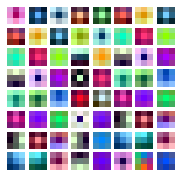

In [39]:
fig, ax = plt.subplots(8,8, figsize=(3, 3))
for i in range(8):
    for j in range(8):
        ax[i,j].imshow (normalize_and_permute(model.features[0].state_dict()['weight'][i * 5 + j].cpu()))
        ax[i,j].axis('off')

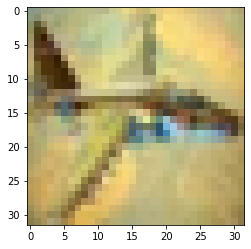

In [40]:
imgs,labels = next (iter (test_loader))
f = model.features[0](imgs.to(device)).to('cpu')
plt.imshow (normalize_and_permute (imgs[0]).cpu())

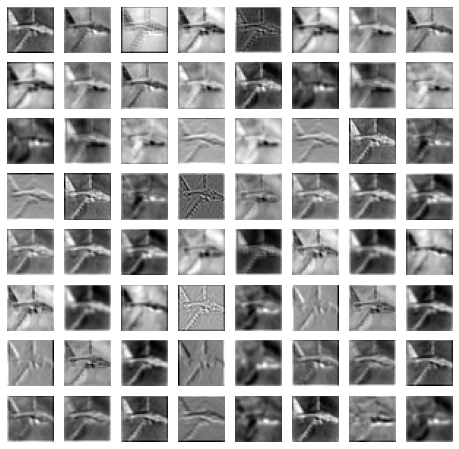

In [41]:
fig, ax = plt.subplots(8,8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i,j].imshow (f.detach().cpu()[0][i * 5 + j], cmap = 'gray')
        ax[i,j].axis('off')

In [53]:

batch = next(iter(test_loader))
x, y = batch
x = x[:6]
y = y[:6]

x = x.to(device)
x = x.requires_grad_(True)


Plotting


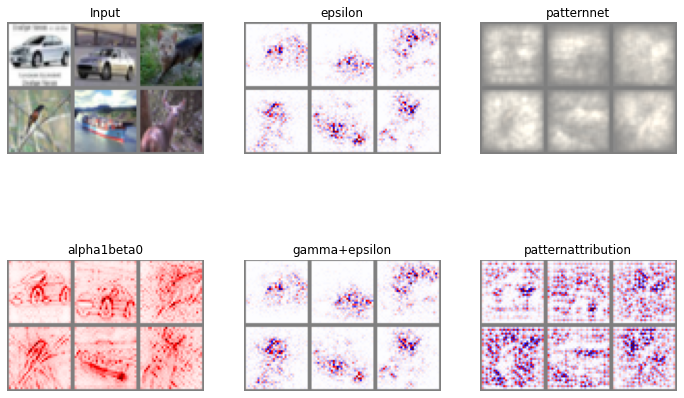

In [54]:
explanations = [
        # rule                  Pattern     plt_fn          Fig. pos
        ('alpha1beta0',         None,       heatmap_grid,   (1, 0)), 
        ('epsilon',             None,       heatmap_grid,   (0, 1)), 
        ('gamma+epsilon',       None,       heatmap_grid,   (1, 1)), 
        ('patternnet',          patterns,   signal_fn,      (0, 2)),
        ('patternattribution',  patterns,   heatmap_grid,   (1, 2)),
    ]

fig, ax = plt.subplots(2, 3, figsize=(12, 8))
print("Plotting")

# Plot inputs
input_to_plot = x.permute(0, 2, 3, 1).contiguous().detach().cpu().numpy()
input_to_plot = grid(input_to_plot, 3, 1.)
ax[0, 0].imshow(input_to_plot)
ax[0, 0].set_title("Input")
ax[0, 0].axis('off')

# Plot explanations
for i, (rule, pattern, fn, (p, q) ) in enumerate(explanations): 
    compute_and_plot_explanation(x, model_lrp, rule, ax[p, q], patterns=pattern, plt_fn=fn)



In [158]:
model_lrp

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum

In [135]:
model_lrp = deepcopy (lrp.convert_vgg(model))
model_lrp = model_lrp.to(device).eval()

In [138]:
xp = model_lrp.forward(x, explain=True, rule=rule, pattern=patterns)

In [140]:
xp

tensor([[-1.5760, 12.1756, -2.7870, -2.3373, -1.7966, -1.5569, -1.9083, -0.3371,
         -0.7184,  0.8779],
        [-0.2654, 12.5737, -3.9308, -1.9659, -0.9233, -2.1611, -2.6247, -1.2625,
         -0.4844,  1.0656],
        [-3.0935, -2.7934,  2.2360, 12.3610,  4.5569, -0.1006, -1.8072, -4.3669,
         -3.8916, -3.0499],
        [-2.8902, -4.1863, 15.7194, -1.4685, -0.7238, -0.9880, -1.1692,  0.4591,
         -2.5026, -2.2562],
        [ 1.9926, -1.2435, -3.2044, -2.2155, -2.8177, -2.4258, -1.7462, -2.2612,
         13.3776,  0.5582],
        [-3.1713, -3.5918, -0.3456,  3.0487, 13.5288,  1.1009, -0.6634, -3.1169,
         -3.4575, -3.2589]], device='cuda:0',
       grad_fn=<LinearPatternAttributionBackward>)

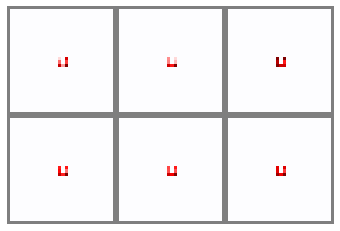

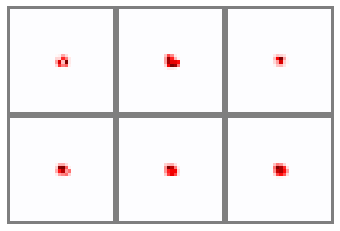

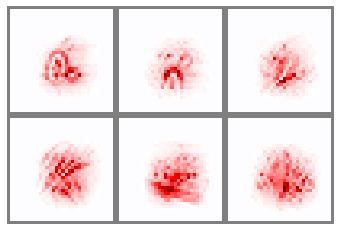

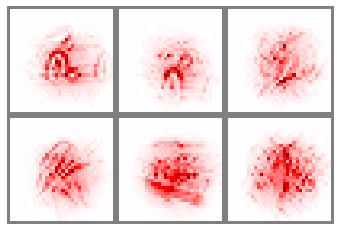

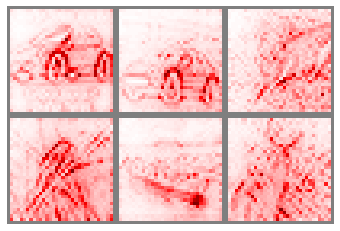

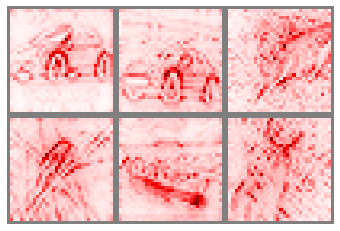

In [179]:
for layer_to_look in [1, 4, 15, 18, 28, 41]:
    new_model = lrp.Sequential(*(model_lrp[:layer_to_look]))
    xp = new_model.forward(x, explain=True, rule=rule, pattern=patterns)

    x = x.to(device)
    x = x.detach()
    x.requires_grad_(True)

    # Forward pass
    y_hat_lrp = new_model.forward(x, explain=True, rule='alpha1beta0', pattern=None)

    # Choose argmax
    _,_,w,h = y_hat_lrp.shape
    y_hat_lrp = y_hat_lrp[:,0,w//2,h//2]
    y_hat_lrp = y_hat_lrp.sum()

    # Backward pass (compute explanation)
    y_hat_lrp.backward()
    attr = x.grad    
    plt_fn = heatmap_grid
    attr = plt_fn(attr)

    plt.imshow(attr)
    plt.axis('off')
    plt.show()